In [ ]:
#Dependencies, in case they are not already installed in the environment
!pip install kaggle --upgrade -q
!pip install numpy --upgrade -q
!pip install opendatasets --upgrade -q
!pip install pandas --upgrade -q
!pip install seaborn --upgrade -q
!pip install matplotlib --upgrade -q

In [1]:
import os
import kaggle
from io import StringIO # For creation of string inputs to be read as '.tsv' by pandas
import re # For separation of netflix_df.country strings into lists
import gzip # For extraction of IMDB datasets
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Data Preparation and Cleaning

### We will download and combine all datasets necessary to our investigation.

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('shivamb/netflix-shows', path=os.getcwd(), unzip=True)

In [3]:
# The 'shivamb/netflix-shows' dataset should have downloaded and been extracted to expose file: 'netflix_titles.csv'
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'Netflix Data Analysis.ipynb',
 'netflix_titles.csv',
 'README.md']

In [4]:
netflix_df_raw = pd.read_csv('netflix_titles.csv')
netflix_df = netflix_df_raw.copy()
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


In [5]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [6]:
netflix_df.shape

(6234, 12)

### The Netflix download does not include any information on how people have rated the titles; the 'rating' column in the above info refers to MPAA rating.  We can get users' rating info from IMDB.  They make their data available at https://datasets.imdbws.com.

In [7]:
#Download IMDB files from official repository
urllib.request.urlretrieve('https://datasets.imdbws.com/title.ratings.tsv.gz', 'title.ratings.tsv.gz');
urllib.request.urlretrieve('https://datasets.imdbws.com/title.basics.tsv.gz', 'title.basics.tsv.gz');

#extract files as text
with gzip.open('title.ratings.tsv.gz', 'rt', encoding='utf8') as reader:
    ratings_contents = reader.read()

with gzip.open('title.basics.tsv.gz', 'rt', encoding='utf8') as reader:
    basics_contents = reader.read()
    
# Create text strings to be loaded into panda.read_csv as a tab separated file
ratings_data = StringIO(ratings_contents)
basics_data = StringIO(basics_contents)

# Create pandas dataframe from tab separated file for ratings
imdb_ratings_df_raw = pd.read_csv(ratings_data, sep='\t')
imdb_ratings_df = imdb_ratings_df_raw.copy()

# Create pandas dataframe from tab separated file for titles
imdb_titles_df_raw = pd.read_csv(basics_data, sep='\t')
imdb_titles_df = imdb_titles_df_raw.copy()

C:\Users\johna\anaconda3\envs\DS\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Since the IMDB database is so vast, it comes in multiple files.  I only grabbed the two that I need to make a connection to the Netflix data: 'title.ratings.tsv' and 'title.basics.tsv'.  The tables are linked with a shared key, 'tconst', used to correctly join the data.  The following table includes all titles with any associated ratings from the entire IMDB database.

In [8]:
imdb_combo_df = pd.merge(imdb_titles_df, imdb_ratings_df, on='tconst')
imdb_combo_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.6,1650
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.1,199
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1359
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.2,121
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2144
...,...,...,...,...,...,...,...,...,...,...,...
1083322,tt9916580,tvEpisode,Horrid Henry Horrid Boy?,Horrid Henry Horrid Boy?,0,2012,\N,10,"Animation,Comedy,Family",7.2,5
1083323,tt9916690,tvEpisode,Horrid Henry Delivers the Milk,Horrid Henry Delivers the Milk,0,2012,\N,\N,"Animation,Comedy,Family",6.6,5
1083324,tt9916720,short,The Nun 2,The Nun 2,0,2019,\N,10,"Comedy,Horror,Mystery",6.0,62
1083325,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,\N,43,"Family,Reality-TV",6.9,14


In [9]:
imdb_combo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1083327 entries, 0 to 1083326
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   tconst          1083327 non-null  object 
 1   titleType       1083327 non-null  object 
 2   primaryTitle    1083326 non-null  object 
 3   originalTitle   1083326 non-null  object 
 4   isAdult         1083327 non-null  int64  
 5   startYear       1083327 non-null  object 
 6   endYear         1083327 non-null  object 
 7   runtimeMinutes  1083327 non-null  object 
 8   genres          1083325 non-null  object 
 9   averageRating   1083327 non-null  float64
 10  numVotes        1083327 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 99.2+ MB


### Now we want just the titles listed in the Kaggle Netflix dataset downloaded from https://www.kaggle.com/shivamb/netflix-shows which also have rating information on IMDB.

In [10]:
#Join the two datasets with the intention of having only the titles on netflix remain, but include their information from IMDB
final_df_raw = pd.merge(netflix_df, imdb_combo_df, left_on='title', right_on='primaryTitle')
final_df = final_df_raw.copy()
final_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,...,movie,Norm of the North: King Sized Adventure,Norm of the North: King Sized Adventure,0,2019,\N,90,"Adventure,Animation,Comedy",3.2,290
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,...,tvSpecial,Jandino: Whatever it Takes,Jandino: Whatever it Takes,0,2016,\N,95,Comedy,5.2,19
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,...,tvSeries,Transformers Prime,Transformers Prime,0,2010,2013,30,"Action,Adventure,Animation",7.9,5290
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,...,tvSeries,Transformers: Robots in Disguise,Toransufômâ: Kârobotto,0,2000,\N,22,"Action,Adventure,Animation",6.8,482
4,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,...,tvSeries,Transformers: Robots in Disguise,Transformers: Robots in Disguise,0,2014,2020,22,"Action,Adventure,Animation",6.0,824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18580,70153404,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,...,tvEpisode,Friends,Friends,0,2016,\N,24,"Action,Animation,Romance",7.9,9
18581,70153404,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,...,tvEpisode,Friends,Friends,0,2017,\N,23,"Adventure,Animation,Drama",7.6,5
18582,70153404,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,...,tvEpisode,Friends,Friends,0,2018,\N,24,"Action,Adventure,Animation",8.4,105
18583,70153404,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,...,tvEpisode,Friends,Friends,0,2018,\N,24,"Action,Adventure,Animation",9.3,3258


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18585 entries, 0 to 18584
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         18585 non-null  int64  
 1   type            18585 non-null  object 
 2   title           18585 non-null  object 
 3   director        12669 non-null  object 
 4   cast            17335 non-null  object 
 5   country         17476 non-null  object 
 6   date_added      18527 non-null  object 
 7   release_year    18585 non-null  int64  
 8   rating          18578 non-null  object 
 9   duration        18585 non-null  object 
 10  listed_in       18585 non-null  object 
 11  description     18585 non-null  object 
 12  tconst          18585 non-null  object 
 13  titleType       18585 non-null  object 
 14  primaryTitle    18585 non-null  object 
 15  originalTitle   18585 non-null  object 
 16  isAdult         18585 non-null  int64  
 17  startYear       18585 non-null 

In [12]:
final_df.isnull().sum()

show_id              0
type                 0
title                0
director          5916
cast              1250
country           1109
date_added          58
release_year         0
rating               7
duration             0
listed_in            0
description          0
tconst               0
titleType            0
primaryTitle         0
originalTitle        0
isAdult              0
startYear            0
endYear              0
runtimeMinutes       0
genres               0
averageRating        0
numVotes             0
dtype: int64

### A few titles had 'NaN' for 'date_added'; notably, the TV show 'Friends'.  Since Friends was such a popular show, I wanted to find a way to include them in the table so I separated them with a dummy date of January 1, 2001.  I also changed 'NaN' values in the 'country' and 'director' columns to the python String 'Unknown' for grouping and comparison purposes; 'NaN' will not evaluate correctly.

In [13]:
final_df.country = final_df.country.fillna('Unknown')
final_df.director = final_df.director.fillna('Unknown')
final_df.date_added = final_df.date_added.fillna('January 1, 2001')

In [14]:
final_df.title.duplicated().sum()

13726

### Hmm, a number of titles seem to be duplicates...  But we know it is the case that more than one movie can share a title...
### We will group the dataframe on 'cast' because there is little chance of accidentally grouping entries together since the 'cast' string is so specific and less likely to appear in multiple entries than, say, 'title'.

In [15]:
final_df = final_df.groupby('cast').agg({'title':'max', 'type':'max', 'director':'max', 'country':'max', 'date_added':'max', 'description':'max', 'averageRating':'mean', 'numVotes':'sum'}).reset_index()

### This leaves us with 4383 original titles, all on Netflix and all with complete IMDB rating information.

In [16]:
final_df.sort_values('numVotes', ascending=False)

,cast,title,type,director,country,date_added,description,averageRating,numVotes
2457,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",Inception,Movie,Christopher Nolan,"United States, United Kingdom","January 1, 2020","In this mind-bending sci-fi thriller, a man ru...",7.585714,2020710
2014,"John Travolta, Samuel L. Jackson, Uma Thurman,...",Pulp Fiction,Movie,Quentin Tarantino,United States,"January 1, 2019",This stylized crime caper weaves together stor...,8.500000,1791086
2242,"Keanu Reeves, Laurence Fishburne, Carrie-Anne ...",The Matrix,Movie,"Lilly Wachowski, Lana Wachowski",United States,"November 1, 2019",A computer hacker learns that what most people...,7.200000,1642842
1173,"Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...",The Lord of the Rings: The Return of the King,Movie,Peter Jackson,"New Zealand, United States","January 1, 2020",Aragorn is revealed as the heir to the ancient...,8.466667,1615358
1174,"Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...",The Lord of the Rings: The Two Towers,Movie,Peter Jackson,"New Zealand, United States","January 1, 2020",Frodo and Sam head to Mordor to destroy the On...,7.600000,1460421
...,...,...,...,...,...,...,...,...,...
2480,"Liev Schreiber, Elisabeth Moss, Ron Perlman, N...",The Bleeder,Movie,Philippe Falardeau,United States,"March 29, 2019","Husband. Father. Fighter. Meet Chuck Wepner, t...",8.000000,5
2044,"Jonathan Howard, Jonathan Demurger, Fanny Vale...",Tarif de nuit,Movie,Julien Seri,France,"March 1, 2018",A night out in Paris quickly unravels when two...,7.600000,5
1831,"Jeanette Aw, Qi Yu Wu, Pierre Png, Dai Xiangyu...",The Little Nyonya,TV Show,Unknown,Unknown,"November 1, 2017",An orphaned Chinese woman in Singapore refuses...,6.800000,5
1804,Javed Akhtar,Classic Legends,TV Show,Unknown,India,"May 15, 2017",This documentary series explores the glamour o...,6.600000,5


In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cast           4384 non-null   object 
 1   title          4384 non-null   object 
 2   type           4384 non-null   object 
 3   director       4384 non-null   object 
 4   country        4384 non-null   object 
 5   date_added     4384 non-null   object 
 6   description    4384 non-null   object 
 7   averageRating  4384 non-null   float64
 8   numVotes       4384 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 308.4+ KB


### We're going to parse the 'date_added' column into individual columns and add another column containing the number of countries each title was released to.

In [18]:
final_df.date_added = pd.to_datetime(final_df.date_added)
#final_df = final_df[final_df.date_added.isna() == False]
final_df['year_added'] = pd.DatetimeIndex(final_df.date_added).year.astype(int)
final_df['month_added'] = pd.DatetimeIndex(final_df.date_added).month.astype(int)
final_df['day_added'] = pd.DatetimeIndex(final_df.date_added).day.astype(int)


# Add a numeric column for the number of countries each title was released to
myList = []
for i in range(final_df.country.size):
    myList.append(final_df.country[i].split(','))

# Make a pandas Series from 'country' list
country = pd.Series(myList)

# Create 'country_count' column using map and lambda function involving 'country' Series
final_df['country_count'] = country.map(lambda x: len(x))

In [19]:
final_df.describe()

,averageRating,numVotes,year_added,month_added,day_added,country_count
count,4384.000000,4.384000e+03,4384.000000,4384.000000,4384.000000,4384.000000
mean,6.580189,3.663063e+04,2018.014370,6.880246,11.720119,1.247947
std,1.073684,1.141751e+05,1.376118,3.669874,10.007476,0.653442
min,1.600000,5.000000e+00,2001.000000,1.000000,1.000000,1.000000
25%,6.000000,5.377500e+02,2017.000000,3.000000,1.000000,1.000000
50%,6.750000,2.829500e+03,2018.000000,7.000000,11.000000,1.000000
75%,7.300000,1.837000e+04,2019.000000,10.000000,20.000000,1.000000
max,9.200000,2.020710e+06,2020.000000,12.000000,31.000000,7.000000


### Above are the mean, standard deviation, min, max and quartiles for numeric columns.

## Exploratory Analysis and Visualization

In [20]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (9, 5)
#matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Here are the number of titles available, where the countries are those with the 10 highest title amounts. 

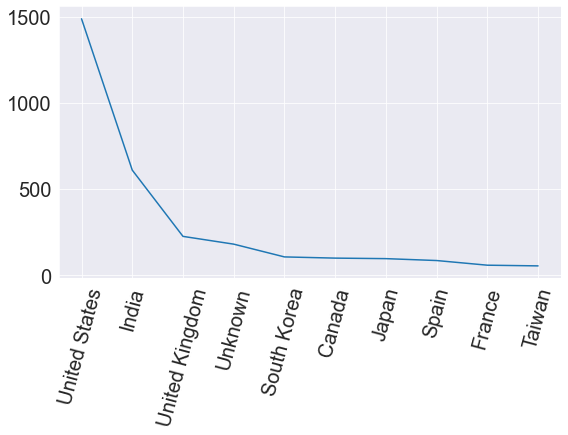

In [21]:
xplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
plt.xticks(rotation=75)
plt.plot(xplt, yplt)

### Let's look at the distribution of values from 'averageRating', 'year_added' and 'month_added' columns, separated into 'Movies' and 'TV Shows'.

6.375557074949635 7.054156142860006


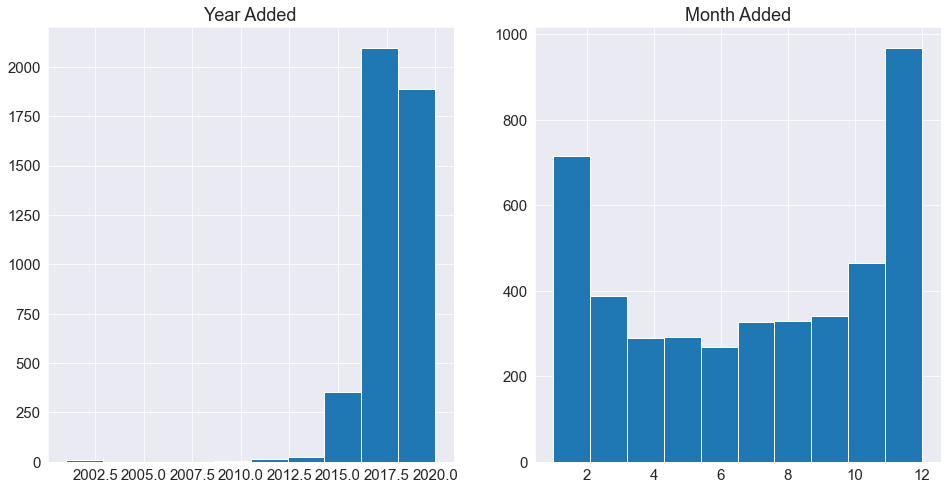

In [25]:
movie_avg = final_df[final_df.type == 'Movie'].averageRating.mean()
tv_avg = final_df[final_df.type == 'TV Show'].averageRating.mean()

print(movie_avg, tv_avg)

matplotlib.rcParams['font.size'] = 15

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].hist(final_df.year_added);
axes[0].set_title('Year Added')
axes[1].hist(final_df.month_added);
axes[1].set_title('Month Added')

padding=(2)

### The content 'uploaded' in 2001/2002 is the content of unkown date which i segregated as 01/01/2001.  Also, it appears that most content is added during the months of December and January; basically, at the new year.

In [26]:
#axes[0].hist([movie_avg, tv_avg], stacked=True);

### Let's see where the ratings are clustered by plotting value density.

#### Ratings below 5

<AxesSubplot:xlabel='averageRating', ylabel='Density'>

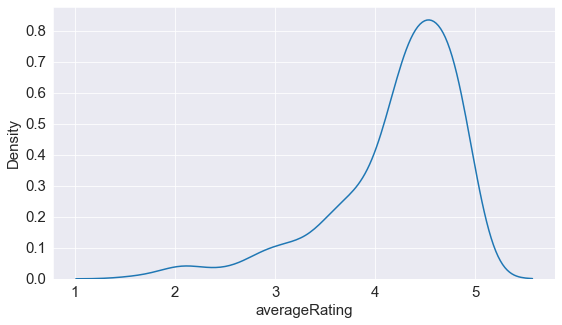

In [27]:
sns.kdeplot(final_df.averageRating[final_df.averageRating < 5.0])

#### Ratings above 5

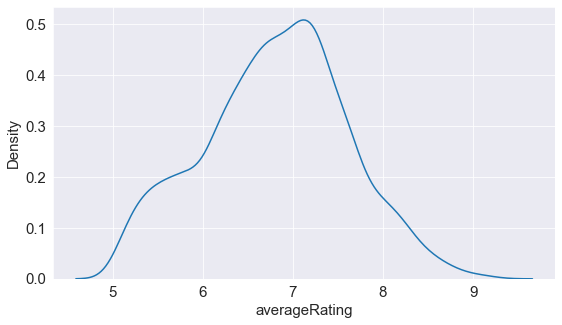

In [28]:
sns.kdeplot(final_df.averageRating[final_df.averageRating > 5.0]);

### These are the ten most commonly used words throughout all of the descriptions, many of them unsurprising.

In [29]:
#
desc_list = []
for desc in netflix_df.description:
    desc = desc.lower()
    desc_list.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list = []
for desc in desc_list:
    for word in desc:
        desc_word_list.append(word.strip())
        
desc_word_pd = pd.DataFrame(desc_word_list, columns=['word'])
        
desc_words_df = pd.DataFrame(desc_word_list, columns=['word'])
desc_words_grp = pd.DataFrame(desc_words_df.groupby('word')['word'].count())
desc_words_grp = desc_words_grp.rename(columns={'word':'frq'})

top_words = pd.DataFrame(desc_words_grp.frq.sort_values(ascending=False).head(1000), columns=['frq']).reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words['percentage'] = top_words.frq.map(lambda x: (x / top_words.frq.sum()) * 100)

top_words.head(10)



,word,frq,percentage
0,a,7983,7.669398
1,the,5860,5.629798
2,to,4542,4.363573
3,and,4482,4.305931
4,of,3884,3.731422
5,in,3171,3.046431
6,his,2344,2.251919
7,with,1553,1.491992
8,her,1460,1.402646
9,an,1365,1.311378


### Interestingly, 'her' is in the list and 'his' is not.

### The pie chart below displays the frequency of all words across all descriptions.  It gets far too illegible; let's break it down further, because...

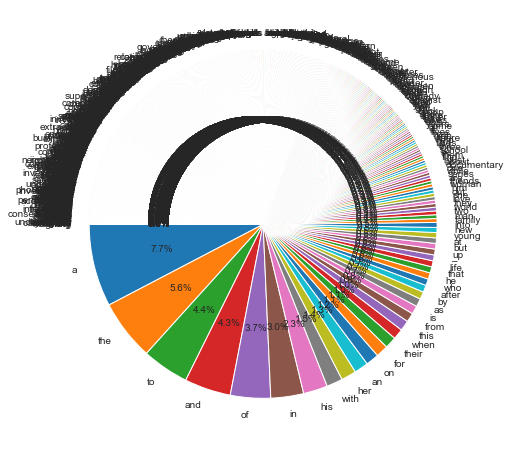

In [30]:
matplotlib.rcParams['font.size'] = 10
plt.figure(figsize=(16, 8))
plt.pie(top_words.frq, labels=top_words.word, autopct='%1.1f%%', startangle=180);
plt.savefig('top_words.jpg')

### ...the top ten words alone make up over 35% of the word usage; of that 35%, the word 'a' makes up over a fifth.

In [31]:
top_words.percentage.head(10).sum()

35.2044884666007

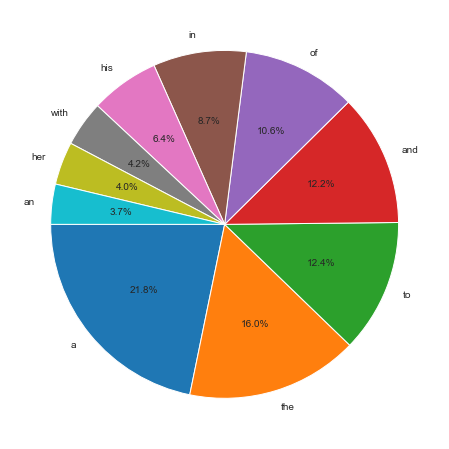

In [32]:
plt.figure(figsize=(16, 8))
plt.fontsize=5
plt.pie(top_words.frq.head(10), labels=top_words.word.head(10), autopct='%1.1f%%', startangle=180);
plt.savefig('top_words_rdx.jpg')

### Word frequency for US in descending order.

In [33]:
netflix_us_df = netflix_df[netflix_df.country == 'United States']

desc_list2 = []
for desc in netflix_us_df.description:
    desc = desc.lower()
    desc_list2.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list2 = []
for desc in desc_list2:
    for word in desc:
        desc_word_list2.append(word.strip())
        
desc_word_pd2 = pd.DataFrame(desc_word_list2, columns=['word'])
        
desc_words_df2 = pd.DataFrame(desc_word_list2, columns=['word'])
desc_words_grp2 = pd.DataFrame(desc_words_df2.groupby('word')['word'].count())
desc_words_grp2 = desc_words_grp2.rename(columns={'word':'frq'})

top_words_us = pd.DataFrame(desc_words_grp2.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_us = top_words_us.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_us['percentage'] = top_words_us.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_us['country'] = 'United States'

top_words_us

,word,frq,percentage,country
0,a,2293,6.784827,United States
1,the,1945,5.755119,United States
2,and,1553,4.595218,United States
3,to,1356,4.012309,United States
4,of,1264,3.740088,United States
...,...,...,...,...
995,using,7,0.020713,United States
996,boxer,7,0.020713,United States
997,serious,7,0.020713,United States
998,water,7,0.020713,United States


### Word frequency for India, in descending order.

In [34]:
netflix_india_df = netflix_df[netflix_df.country == 'India']

desc_list3 = []
for desc in netflix_india_df.description:
    desc = desc.lower()
    desc_list3.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list3 = []
for desc in desc_list3:
    for word in desc:
        desc_word_list3.append(word.strip())
        
desc_word_pd3 = pd.DataFrame(desc_word_list3, columns=['word'])
        
desc_words_df3 = pd.DataFrame(desc_word_list3, columns=['word'])
desc_words_grp3 = pd.DataFrame(desc_words_df3.groupby('word')['word'].count())
desc_words_grp3 = desc_words_grp3.rename(columns={'word':'frq'})

top_words_india = pd.DataFrame(desc_words_grp3.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_india = top_words_india.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_india['percentage'] = top_words_india.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_india['country'] = 'India'

top_words_india

,word,frq,percentage,country
0,a,1249,3.695704,India
1,to,662,1.958812,India
2,the,634,1.875962,India
3,of,489,1.446917,India
4,and,446,1.319683,India
...,...,...,...,...
995,taxi,3,0.008877,India
996,demands,3,0.008877,India
997,desires,3,0.008877,India
998,twins,3,0.008877,India


### Word frequency for UK, in descending order.

In [35]:
netflix_uk_df = netflix_df[netflix_df.country == 'United Kingdom']

desc_list4 = []
for desc in netflix_uk_df.description:
    desc = desc.lower()
    desc_list4.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list4 = []
for desc in desc_list4:
    for word in desc:
        desc_word_list4.append(word.strip())
        
desc_word_pd4 = pd.DataFrame(desc_word_list4, columns=['word'])
        
desc_words_df4 = pd.DataFrame(desc_word_list4, columns=['word'])
desc_words_grp4 = pd.DataFrame(desc_words_df4.groupby('word')['word'].count())
desc_words_grp4 = desc_words_grp4.rename(columns={'word':'frq'})

top_words_uk = pd.DataFrame(desc_words_grp4.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_uk = top_words_uk.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_uk['percentage'] = top_words_uk.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_uk['country'] = 'United Kingdom'

top_words_uk

,word,frq,percentage,country
0,the,396,1.171736,United Kingdom
1,a,315,0.932063,United Kingdom
2,and,275,0.813706,United Kingdom
3,of,245,0.724938,United Kingdom
4,to,199,0.588827,United Kingdom
...,...,...,...,...
995,educator,1,0.002959,United Kingdom
996,gromit,1,0.002959,United Kingdom
997,electronic,1,0.002959,United Kingdom
998,elements,1,0.002959,United Kingdom


### The top five words for all the countries are identical, except for their position on the list.

In [ ]:
#movies_added = no_2001[no_2001.type == 'Movie'].groupby('year_added')['title'].count()
#movies_added

#tv_added = no_2001[no_2001.type == 'TV Show'].groupby('year_added')['title'].count()
#tv_added

#no_2001 = final_df[final_df.year_added != 2001]
#years = sorted(no_2001.year_added.unique())
#tv = tv_added.to_list()
#movies = movies_added.to_list()
#print(years, tv, movies)

In [ ]:
#plt.plot(years, tv, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy');
#plt.plot(years, movies, 'r--o', linewidth=4, markersize=12);
#plt.title('Movies and TV Shows added to Netflix By Year')
#plt.legend(['Movies', 'TV Shows'])
#plt.xlabel('Year'); plt.ylabel('Titles Added');

### Now let's look at some of the least common words.

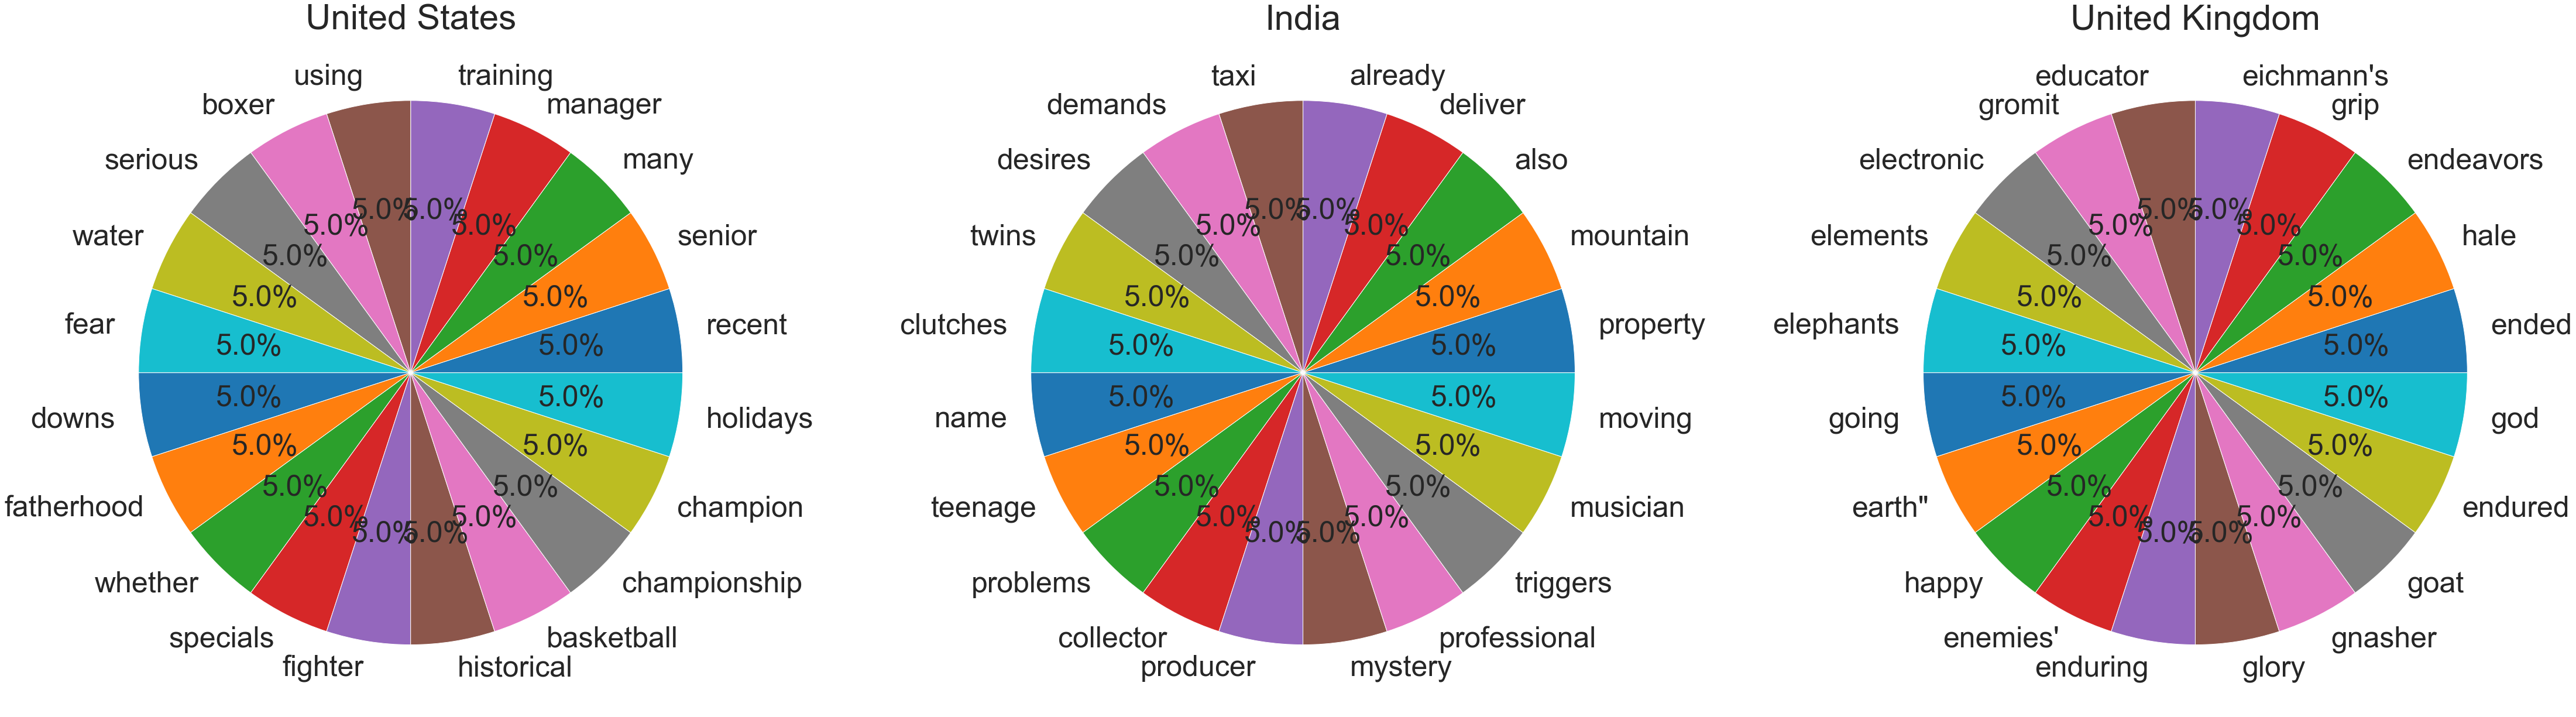

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(64, 32))
matplotlib.rcParams['font.size'] = 50
axes[0].pie(top_words_us.frq.tail(20), labels=top_words_us.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[0].set_title('United States')
axes[1].pie(top_words_india.frq.tail(20), labels=top_words_india.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[1].set_title('India')
axes[2].pie(top_words_uk.frq.tail(20), labels=top_words_uk.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[2].set_title('United Kingdom')

plt.tight_layout(pad=2);

### The above pie charts show the 20 least common descriptive words for US, India and UK.

### Below is a scatterplot of word frequency by country (US, India, UK).

C:\Users\johna\anaconda3\envs\DS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


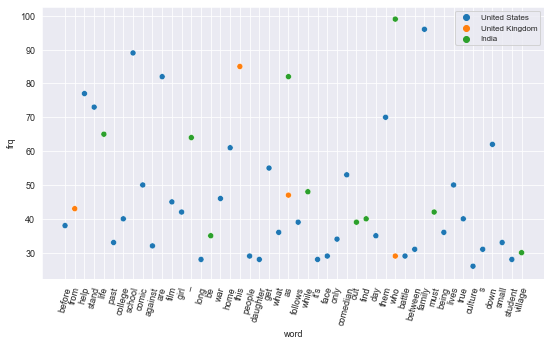

In [37]:
conc = pd.concat([top_words_us, top_words_india, top_words_uk])
conc

matplotlib.rcParams['font.size'] = 9
plt.xticks(rotation=75)
matplotlib.rcParams['font.size'] = 8
conc_sample = conc[(conc.frq > 25) & (conc.frq < 100)].sample(50)
sns.scatterplot(conc_sample.word, conc_sample.frq, hue=conc_sample.country.tolist());

## Asking and Answering Questions

### Explore differences between, as well as similarities among, content available in different countries

### Question 1: What are the least common words used in description?

In [38]:
desc_list = []
for desc in netflix_df.description:
    desc = desc.lower()
    desc_list.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list = []
for desc in desc_list:
    for word in desc:
        desc_word_list.append(word.strip())
        
desc_word_pd = pd.DataFrame(desc_word_list, columns=['word'])
        
desc_words_df = pd.DataFrame(desc_word_list, columns=['word'])
desc_words_grp = pd.DataFrame(desc_words_df.groupby('word')['word'].count())
desc_words_grp = desc_words_grp.rename(columns={'word':'frq'})

top_words = pd.DataFrame(desc_words_grp.frq.sort_values(ascending=False).head(1000), columns=['frq']).reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words['percentage'] = top_words.frq.map(lambda x: (x / top_words.frq.sum()) * 100)

In [39]:
uc_words = top_words[top_words.frq <= 50].sample(100).tail(10)[['word', 'frq', 'percentage']].reset_index().drop('index', axis=1)
uc_words.sort_values('frq', ascending=False)

,word,frq,percentage
7,end,45,0.043232
9,play,38,0.036507
1,made,36,0.034586
5,fame,35,0.033625
2,offers,32,0.030743
8,trapped,31,0.029782
0,businessman,28,0.026900
6,wrong,28,0.026900
3,crush,23,0.022096
4,universe,20,0.019214


### Here we have a list of 10 of the LEAST commonly used words, generated by taking the tail of a random sample of 100 of the words whose frequency is 75 or less.

### Question 2: Which country consistently gives the highest ratings?

In [40]:
us_ratings = final_df[final_df.country == 'United States'].averageRating
uk_ratings = final_df[final_df.country == 'United Kingdom'].averageRating
india_ratings = final_df[final_df.country == 'India'].averageRating

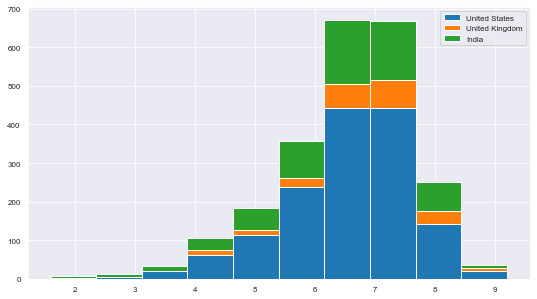

In [41]:
plt.hist([us_ratings, uk_ratings, india_ratings], 
         stacked=True);
plt.legend(['United States', 'United Kingdom', 'India']);

### Question 3: Because India consistently gives the highest ratings to its available content, which type of content is preferred in India: Movie or TV Show?

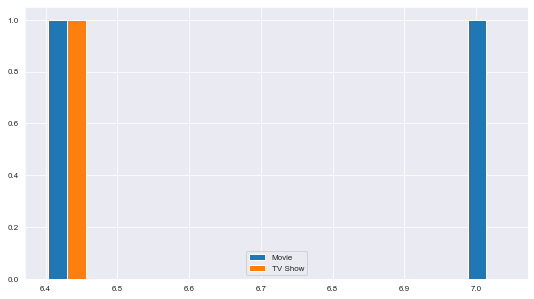

In [42]:
india_rating_tv = final_df[(final_df.country == 'India')].groupby('type')['averageRating'].mean()
india_rating_movie = final_df[(final_df.country == 'India') & (final_df.type == 'Movie')]['averageRating'].mean()

plt.hist([india_rating_tv, india_rating_movie]);

plt.legend(['Movie', 'TV Show']);

### It appears that India, as a country, prefers the TV Shows on Netflix over the Movies.

### Question 4: Does Netflix availability follow the Pareto Distribution?

### For the Pareto Distribution to hold for overall access to content by country, the top 20% of the countries in the list of content amount should account for 80% of the overall usage.  Let's see if this is the case.

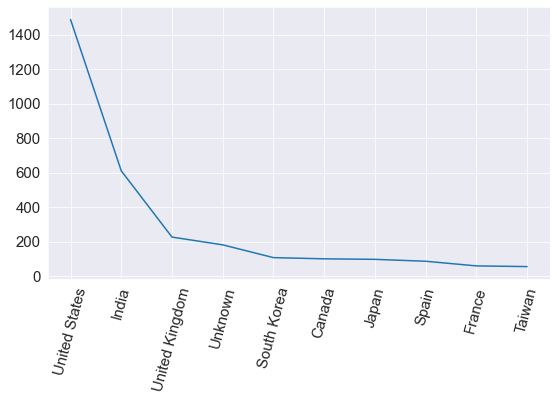

In [44]:
matplotlib.rcParams['font.size'] = 15

xplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
plt.xticks(rotation=75)
plt.plot(xplt, yplt)

### This graph closely mirrors a Pareto Distribution.

## Inferences and Conclusion

### There are obviously many interrelations between the data in this set, however, it appears that a prime takeaway is that TV Shows are valued more than movies in today's world;  in addition, it appears that India is a fast growing market which uses the rating system more favorably than some other, Western countries.

## References and Future Work

* https://www.kaggle.com/shivamb/netflix-shows
* https://datasets.imdbws.com/

* There should be more care taken when comparing titles by country.  There are a number of titles which are available in multiple countries and these combinations are counted as their own 'country'.